In [3]:
import os
if os.getcwd().split("/")[-1] == "notebooks":
    os.chdir(os.pardir)

import jax
import jax.numpy as jnp
from jax import grad, value_and_grad, jit, vmap
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.auto import trange

from src.utils.viz import set_axes_equal

In [4]:
print(f'platform: {jax.lib.xla_bridge.get_backend().platform}')

platform: cpu


In [39]:
sns.set(style='ticks', palette='colorblind')

In [6]:
%config InlineBackend.figure_format = 'retina'

In [8]:
PROJECT_NAME = 'ACROSS-RuWorkshop2021_presentation'

In [14]:
def plot_2d(xy_dict, figsize=plt.rcParams['figure.figsize'], c=None, alpha=1):
    fig = plt.figure(figsize=figsize)
    ax = plt.axes()
    keys = list(xy_dict.keys())
    values = list(xy_dict.values())
    if (len(values) == 3) and not(c):
        cs = ax.scatter(values[0], values[1], c=values[2])
        cbar = fig.colorbar(cs)
        cbar.ax.set_ylabel(keys[2])
    else:
        if not(c):
            c = 'k'
        cs = ax.scatter(values[0], values[1], c=c, alpha=alpha)
    ax.set(xlabel=keys[0], ylabel=keys[1])
    
    ax.axis('equal')
    fig.tight_layout()
    return fig, ax


def plot_3d(xyz_dict, figsize=plt.rcParams['figure.figsize'], elev=20, azim=60,
            c=None, alpha=1):
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection ='3d')
    keys = list(xyz_dict.keys())
    values = list(xyz_dict.values())
    if (len(values) == 4) and not(c):
        cs = ax.scatter(values[0], values[1], values[2], c=values[3])
        cbar = fig.colorbar(cs, shrink=0.5)
        cbar.ax.set_ylabel(keys[3])
    else:
        if not(c):
            c = 'k'
        cs = ax.plot(values[0], values[1], values[2], '.', c=c, alpha=alpha)
    ax.set(xlabel=keys[0], ylabel=keys[1], zlabel=keys[2])
    ax = set_axes_equal(ax)
    ax.view_init(elev, azim)
    fig.tight_layout()
    return fig, ax

# Surface integral

In [15]:
def Z_fn(X, Y):
    """Return the parametrization of a paraboloid."""
    return 1 - X ** 2 - Y ** 2

In [16]:
x = np.linspace(-1, 1)
y = np.linspace(-1, 1)
X, Y = np.meshgrid(x, y)
Z = Z_fn(X, Y)

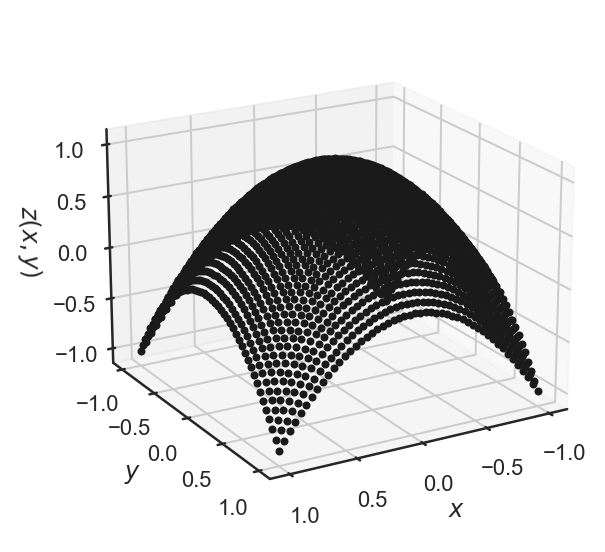

In [17]:
# visualize in 3-D
fig, ax = plot_3d(xyz_dict={'$x$': X.flatten(),
                            '$y$': Y.flatten(),
                            '$z(x, y)$': Z.flatten()})

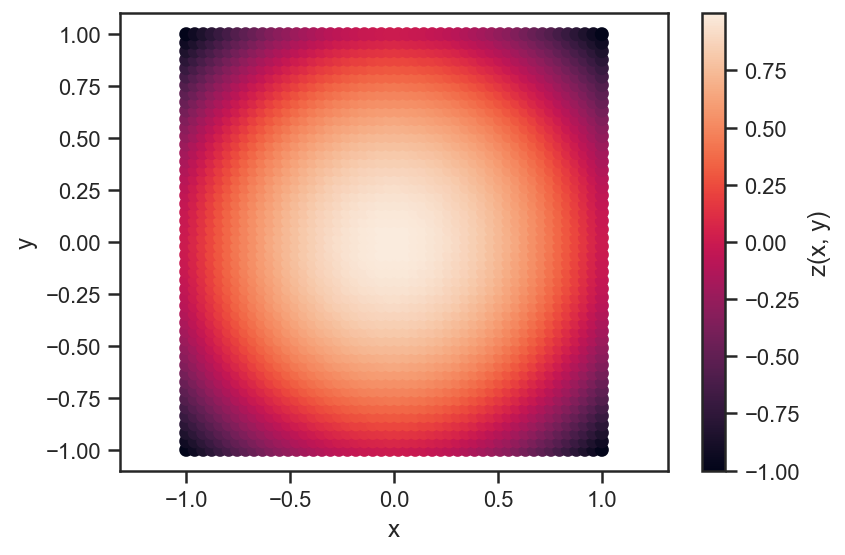

In [18]:
# visualize from the xy-plane point of view
fig, ax = plot_2d(xy_dict={'x': X.flatten(),
                           'y': Y.flatten(),
                           'z(x, y)': Z.flatten()})

In [19]:
points = np.c_[X.flatten(), Y.flatten()]
values = Z.flatten()
DEG = 2
init_params = np.random.randn((DEG+1) ** points.shape[1])
lr = 0.01
n_epochs = 5_000

In [20]:
def model(x, params):
    """Return the polynomial approximation over `x`."""
    x = jnp.atleast_2d(x)
    degrees = [jnp.array([i, j]) for i in range(DEG+1) for j in range(DEG+1)]
    design_matrix = jnp.stack([jnp.prod(x ** d, axis=1)
                               for d in degrees], axis=-1)
    y = design_matrix @ params
    return y.flatten()

In [21]:
def metric(y_true, y_pred):
    """Return mean squared error between true and predicted data."""
    return jnp.mean((y_true - y_pred) ** 2)

In [22]:
def loss_fn(params, x, y):
    """Return loss function value for current state of parameters."""
    y_pred = model(x, params)
    return metric(y, y_pred)

In [23]:
# gradient of the loss function with regards to parameters
value_and_grad_loss_fn = jit(value_and_grad(loss_fn))

In [24]:
# fitting loop
loss_value_list = []
loss_grad_list = []
opt_params = init_params
for epoch in trange(n_epochs):
    loss_value, loss_grad = value_and_grad_loss_fn(opt_params, points, values)
    loss_value_list.append(loss_value)
    loss_grad_list.append(loss_grad)
    opt_params = opt_params - lr * loss_grad

  0%|          | 0/5000 [00:00<?, ?it/s]

In [25]:
# legendre roots and weights
r, w = np.polynomial.legendre.leggauss(33)
xr = 0.5 * (r + 1.) * (x.max() - x.min()) + x.min()
xw = 0.5 * w * (X.max() - X.min())
yr = 0.5 * (r + 1.) * (y.max() - y.min()) + y.min()
yw = 0.5 * w * (Y.max() - Y.min())
Xr, Yr = np.meshgrid(xr, yr)
Xw, Yw = np.meshgrid(xw, yw)
Zr = model(np.c_[Xr.flatten(), Yr.flatten()], opt_params)

# extract point cloud for positive z(x, y)
mask = np.where(Zr >= 0)[0]
Xr_target = Xr.flatten()[mask]
Yr_target = Yr.flatten()[mask]
Xw_target = Xw.flatten()[mask]
Yw_target = Yw.flatten()[mask]
Zr_target = Zr[mask]

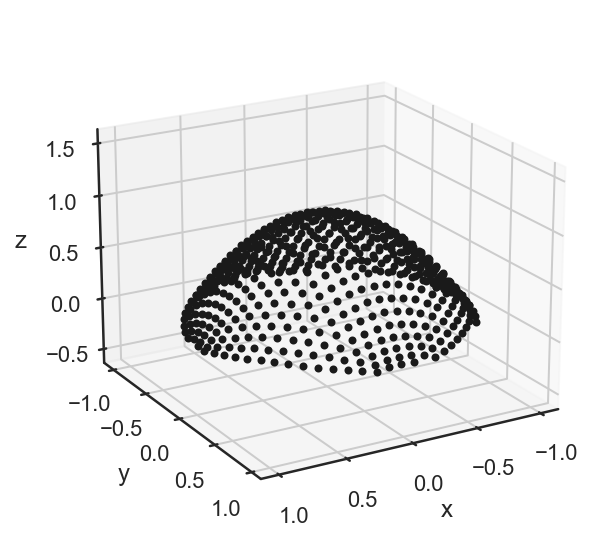

In [26]:
# visualize in 3-D
fig, ax = plot_3d({'$x$': Xr_target,
                   '$y$': Yr_target,
                   '$z$': Zr_target})

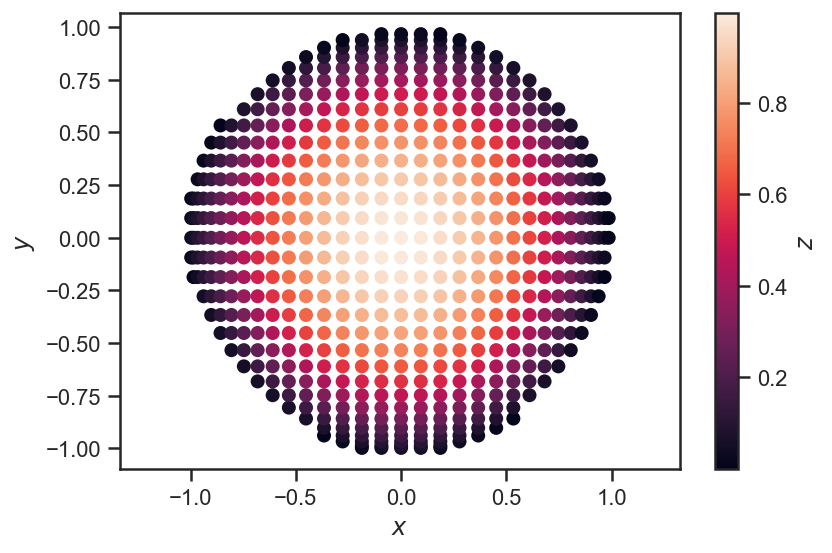

In [35]:
# visualize from the xy-plane point of view
fig, ax = plot_2d({'$x$': Xr_target,
                   '$y$': Yr_target,
                   '$z$': Zr_target})

In [36]:
def z_fit(xy, params):
    """Return a z-value for corresponding xy-pair."""
    xy = jnp.atleast_2d(xy)
    degrees = [jnp.array([i, j]) for i in range(DEG+1) for j in range(DEG+1)]
    design_matrix = jnp.stack([jnp.prod(xy ** d, axis=1)
                               for d in degrees], axis=-1)
    z = design_matrix @ params
    return z[0]


# jacobian matrix (dz/dx, dz/dy)
Jz = vmap(grad(z_fit), in_axes=(0, None))

In [37]:
# normal vectors and associated absolute values
jac = Jz(jnp.c_[Xr_target, Yr_target], opt_params)
nx = jac[:, 0]
ny = jac[:, 1]
nz = np.ones_like(nx)
n_abs = np.sqrt(nx ** 2 + ny ** 2 + 1)

# unit normal vectors
n0x = -nx / n_abs
n0y = -ny / n_abs
n0z = nz / n_abs

# surface area
I = sum(n_abs * Xw_target * Yw_target)
I_theor = np.pi / 6 * (5 * np.sqrt(5) - 1)

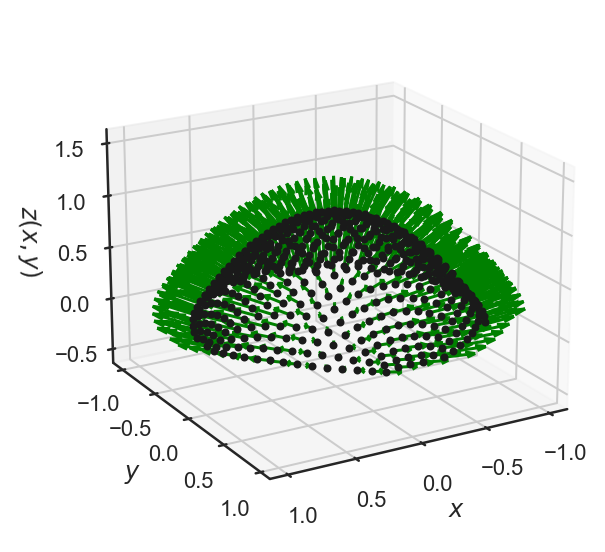

In [47]:
# 3-D visualization
fig, ax = plot_3d({'$x$': Xr_target,
                   '$y$': Yr_target,
                   '$z(x, y)$': Zr_target})

# add normals to visualization
ax.quiver3D(Xr_target, Yr_target, Zr_target,
            n0x, n0y, n0z,
            length=0.3, color='green');

# Flux

In [48]:
def F_fn(x, y, z):
    return np.vstack((x ** 2, y ** 2, z ** 2)).T

In [51]:
F_field = F_fn(Xr_target, Yr_target, Zr_target)
F_magnitude = np.linalg.norm(F_field, axis=1)

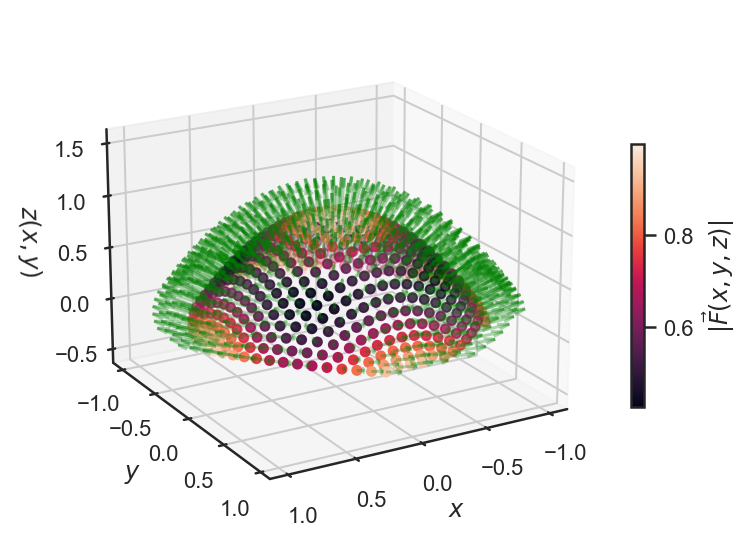

In [59]:
fig, ax = plot_3d({'$x$': Xr_target,
                   '$y$': Yr_target,
                   '$z(x, y)$': Zr_target,
                   r'$|\vecF(x, y, z)|$': F_magnitude})
ax.quiver3D(Xr_target, Yr_target, Zr_target,
            n0x, n0y, n0z,
            length=0.3, color='green', alpha=0.3);

In [61]:
# scalar product between field and associated normals
Fn = F_field[:, 0] * nx + F_field[:, 1] * ny + F_field[:, 2] * nz

# Gauss quadrature
I = sum(Fn * Xw_target * Yw_target)